In [1]:
import sys
sys.path.append("/home/federico/programming/CM/")
# sys.path.append("/home/federico/Desktop/University/CM/")


from Network import NR, NC
import src.utils as utils
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from matplotlib import pyplot as plt

In [2]:
def plot_stats(conf, dataset, test, net, save=False, log=True):
    print(conf)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, log=log)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, time=True, log=log)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save, log=log)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save, time=True, log=log)

    net.plot_grad(f"{dataset}_{test}", save=save)
    print(net.best_score())

In [6]:
def report_plots(dataset, net_SGD, net_SGD_nest, net_SGM, score=False):
    
    sgd_loss = net_SGD.train_loss
    sgd_nest_loss = net_SGD_nest.train_loss
    sgm_loss = net_SGM.train_loss

    # Conditional configuration
    x_label_time = 'Execution Time'
    x_label_ep = 'Epochs'

    train_res_SGD = net_SGD.train_scores if score else net_SGD.train_loss
    train_res_SGD_nest = net_SGD_nest.train_scores if score else net_SGD_nest.train_loss
    train_res_SGM = net_SGM.train_scores if score else net_SGM.train_loss
    x_SGD_time = net_SGD.epochs_time
    x_SGD_ep = list(range(len(train_res_SGD)))
    x_SGD_nest_time = net_SGD_nest.epochs_time
    x_SGD_nest_ep = list(range(len(train_res_SGD_nest)))
    x_SGM_time = net_SGM.epochs_time
    x_SGM_ep = list(range(len(train_res_SGM)))
    
    
    print("----- SGD -----")
    print(params[dataset]['SGD'])
    print(net_SGD.best_score(),"\n")
    
    print("----- SGD nesterov-----")
    print(params[dataset]['SGD'])
    print(net_SGD_nest.best_score(),"\n")

    print("----- SGM -----")
    print(params[dataset]['SGM'])
    print(net_SGM.best_score(),"\n")

    def plot_internal(x_datas, y_datas, x_label, y_label, title):
        plt.semilogy(x_datas[0], y_datas[0], '--', label='SGD CM')
        plt.semilogy(x_datas[1], y_datas[1], '--', label='SGD NAG')
        plt.semilogy(x_datas[2], y_datas[2], '--', label='SGM')
        plt.xlabel(x_label)
        plt.ylabel (y_label)
        plt.legend(loc='best')
        plt.title (title)
        plt.show()
        plt.clf()

    plot_internal([x_SGD_time, x_SGD_nest_time, x_SGM_time], 
                  [train_res_SGD, train_res_SGD_nest, train_res_SGM],
                  x_label_time, 
                  'Loss', 
                  f'Loss NN {dataset} dataset'
                 )
    
    plot_internal([x_SGD_ep, x_SGD_nest_ep, x_SGM_ep], 
                  [train_res_SGD, train_res_SGD_nest, train_res_SGM],
                  x_label_time, 
                  'Loss', 
                  f'Loss NN {dataset} dataset'
                 )
    
    plot_internal([x_SGD_ep, x_SGD_nest_ep, x_SGM_ep], 
                  [net_SGD.grad_est_per_epoch, net_SGD_nest.grad_est_per_epoch, net_SGM.grad_est_per_epoch],
                  x_label_time, 
                  'Loss', 
                  f'Gradient norms for both SGD and SGM over {dataset}'
                 )

In [7]:
def report_stats(params, dataset, score=False, debug=False):
    if dataset == 'cup':
        nn = NR
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
    else:
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC

    # Plots together results from SGD and SGM
    param_SGD = params[dataset]['SGD'].copy()
    param_SGD_nest = params[dataset]['SGD'].copy()
    param_SGM = params[dataset]['SGM'].copy()
    
    param_SGD['debug'] = debug
    net_SGD = nn(**param_SGD)

    param_SGD_nest['debug'] = debug
    param_SGD_nest['nesterov'] = True
    net_SGD_nest = nn(**param_SGD_nest)

    param_SGM['debug'] = debug
    net_SGM = nn(**param_SGM)    

    net_SGD.fit(X_train, y_train)
    net_SGD_nest.fit(X_train, y_train)
    net_SGM.fit(X_train, y_train)

    return net_SGD, net_SGD_nest, net_SGM

In [8]:
datasets = {
    'cup': '../../data/ML-CUP20-TR.csv',
    'monk1': '../../data/monks-1',
    'monk2': '../../data/monks-2', 
    'monk3': '../../data/monks-3', 
}


# TODO: aggiungere json di configurazione
params = {
    'cup': {
        'SGD': {
            'batch_size': 32,
            'epochs': 1000,
            'eps': 1e-6,
            'eta': 0.001,
            'lmbda': 0.001,
            'momentum': 0.,
            'optimizer': "SGD",
            'sizes': [30, 50],
            'debug': True,
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 1000,
            'eps':1e-6,
            'eta': 0.01,
            'lmbda': 0.,
            'optimizer': "SGM",
            'sizes': [50, 50],
            'debug': True,
        }
    },
    'monk1': {
        'SGD': {
            'batch_size': 32,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'momentum': 0.9,
            'nesterov': True,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.3,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True
        }
    },
    'monk2': {
        'SGD': {
            'batch_size': None,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.7,
            'lmbda': 0.01,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': None,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.7,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True,
        }
    },
    'monk3': {
        'SGD': {
            'batch_size': 32,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.5,
            'lmbda': 0.01,
            'momentum': 0.,
            'nesterov': True,
            'optimizer': "SGD",
            'sizes': [2],
            'debug': True
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.7,
            'lmbda': 0.0001,
            'optimizer': "SGM",
            'sizes': [3],
            'debug': True,
        }
    }
}

## Testing configuration

In [9]:
def plot_net(net, dataset, test):
    net.plot_results(f"{dataset}_{test}", score=False, time=True, log=True)
    net.plot_results(f"{dataset}_{test}", score=False, time=False, log=True)
    net.plot_results(f"{dataset}_{test}", score=True, time=True)
    net.plot_results(f"{dataset}_{test}", score=True, time=False)
    net.plot_grad(f"{dataset}_{test}", time=True)

    print(net.best_score(name=f"{dataset}_{test}", save=False))

### Monk1

In [10]:
dataset = 'monk1'

monk1 = {
    'SGD': {
        'batch_size': 32,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.1,
        'lmbda': 0.01,
        'momentum': 0.9,
        'nesterov': False,
        'optimizer': "SGD",
        'sizes': [5],
        'debug': True
    },
    'SGD_nest': {
        'batch_size': 32,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.1,
        'lmbda': 0.01,
        'momentum': 0.9,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [5],
        'debug': True
    },
    'SGM': {
        'batch_size': 32,
        'epochs': 2000,
        'eps':1e-6,
        'eta': 0.3,
        'lmbda': 0.01,
        'optimizer': "SGM",
        'sizes': [5],
        'debug': True
    }
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk1'])
nn = NC
    
net_SGD = nn(**monk1['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk1['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGM = nn(**monk1['SGM'])
net_SGM.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 1.21740e-01 || Loss: 1.33907e-01, 1.33394e-01 || Score: 0.525, 0.532
2       || Gradient norm: 1.47351e-01 || Loss: 1.26939e-01, 1.23300e-01 || Score: 0.539, 0.548
3       || Gradient norm: 1.71368e-01 || Loss: 1.23082e-01, 1.16765e-01 || Score: 0.565, 0.629
4       || Gradient norm: 1.75391e-01 || Loss: 1.19876e-01, 1.11534e-01 || Score: 0.586, 0.629
5       || Gradient norm: 1.60079e-01 || Loss: 1.15907e-01, 1.05645e-01 || Score: 0.625, 0.702
6       || Gradient norm: 1.25103e-01 || Loss: 1.12269e-01, 1.00292e-01 || Score: 0.655, 0.758
7       || Gradient norm: 1.01117e-01 || Loss: 1.09687e-01, 9.62814e-02 || Score: 0.662, 0.742
8       || Gradient norm: 9.13646e-02 || Loss: 1.07514e-01, 9.28186e-02 || Score: 0.671, 0.75 
9       || Gradient norm: 9.32631e-02 || Loss: 1.05143e-01, 8.93142e-02 || Score: 0.681, 0.766
10      || Gradient norm: 9.95045e-02 || Loss: 1.02850e-01, 8.60973e-02 || Score: 0.697, 0.798
11      || Gradient norm: 1.03937e-01 || Loss: 1.0

NC(batch_size=32, debug=True, epochs=2000, eps=1e-06, eta=0.3, lmbda=0.01,
   optimizer='SGM', sizes=[5])

----- SGD CM -----


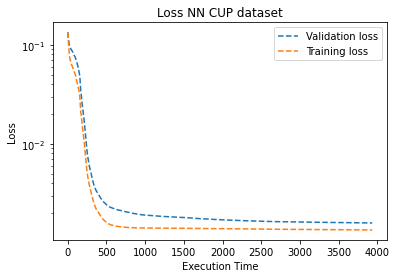

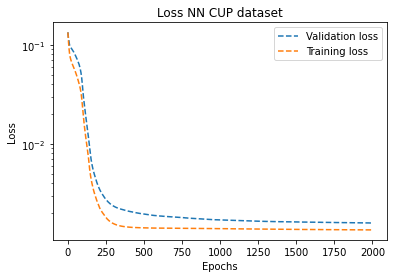

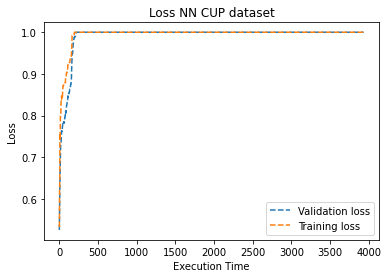

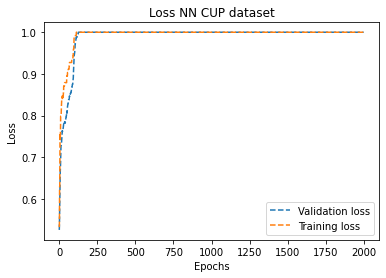

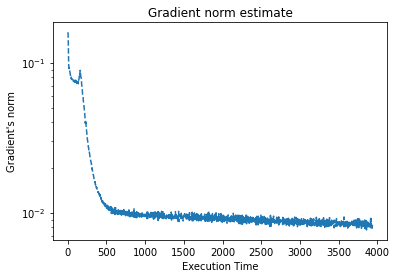

ep: 2000    | s: [5] | b: 32 | e:  0.1 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 9.50856e-03 | Loss: 1.58473e-03, 1.34951e-03 | Score:     1, 1    
ended in: 3933.368, avg per ep: 1.9666839999999999
total update: 0.927, avg updt: 0.00046350000000000004
total ff: 12000, total ff time: 1272.3780000000022, avg ff: 0.10603150000000018
total bp: 8000, total bp time: 636.335000000002, avg bp: 0.07954187500000025
total ev: 2000, total ev time: 1474.0639999999996, avg ev: 0.7370319999999998


----- SGD NAG -----


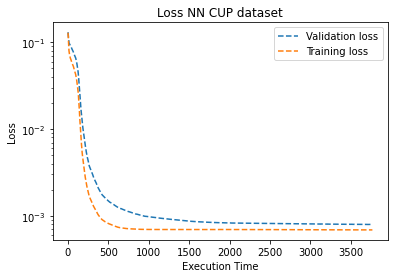

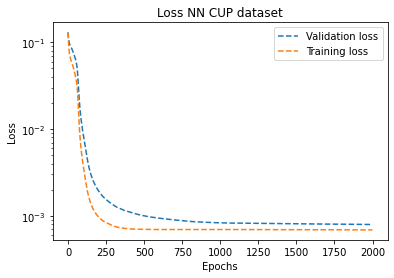

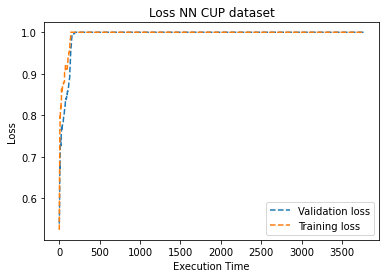

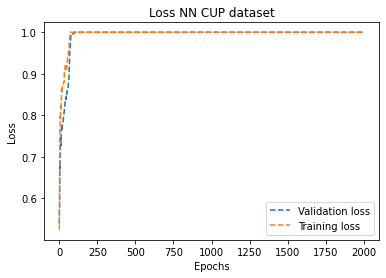

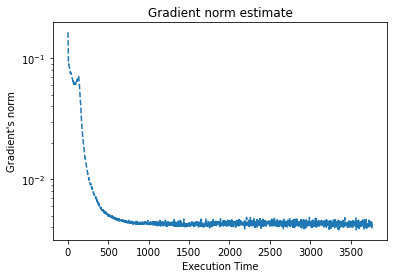

ep: 2000    | s: [5] | b: 32 | e:  0.1 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 5.31102e-03 | Loss: 7.94958e-04, 6.88650e-04 | Score:     1, 1    
ended in: 3766.68, avg per ep: 1.88334
total update: 1.429, avg updt: 0.0007145000000000001
total ff: 12000, total ff time: 1196.0020000000065, avg ff: 0.09966683333333388
total bp: 8000, total bp time: 594.6510000000031, avg bp: 0.0743313750000004
total ev: 2000, total ev time: 1359.9950000000017, avg ev: 0.6799975000000008


----- SGM -----


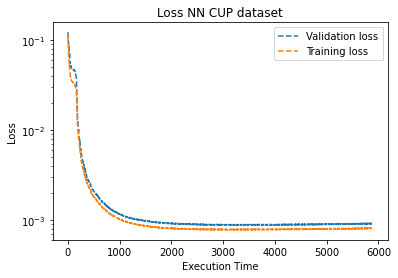

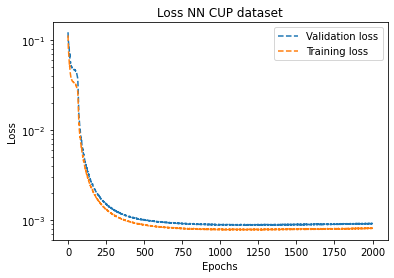

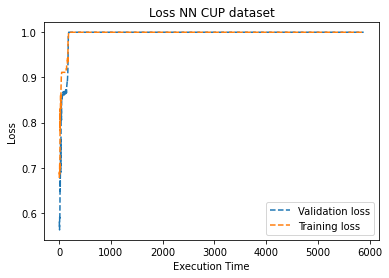

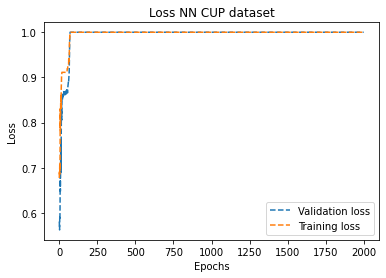

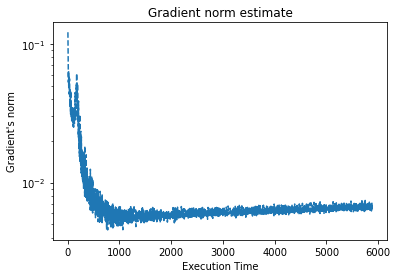

ep: 2000    | s: [5] | b: 32 | e:  0.3 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 2.84550e-03 | Loss: 8.69476e-04, 7.75257e-04 | Score:     1, 1    
ended in: 5884.725, avg per ep: 2.9423625
total update: 2.578, avg updt: 0.001289
total ff: 12000, total ff time: 1320.8529999999962, avg ff: 0.11007108333333301
total bp: 8000, total bp time: 2320.146999999997, avg bp: 0.29001837499999966
total ev: 2000, total ev time: 1475.6189999999967, avg ev: 0.7378094999999983




<Figure size 432x288 with 0 Axes>

In [11]:
print("----- SGD CM -----")
plot_net(net_SGD, dataset, 'SGD')
print("----- SGD NAG -----")
plot_net(net_SGD_nest, dataset, 'SGD_nest')
print("----- SGM -----")
plot_net(net_SGM, dataset, 'SGM')

### Monk2

In [13]:
dataset = 'monk2'

monk2 = {
    'SGD': {
        'batch_size': None,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.7,
        'lmbda': 0.01,
        'momentum': 0.9,
        'nesterov': False,
        'optimizer': "SGD",
        'sizes': [5],
        'debug': True
    },
    'SGD_nest': {
        'batch_size': None,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.7,
        'lmbda': 0.01,
        'momentum': 0.9,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [5],
        'debug': True
    },
    'SGM': {
        'batch_size': None,
        'epochs': 2000,
        'eps':1e-6,
        'eta': 0.7,
        'lmbda': 0.01,
        'optimizer': "SGM",
        'sizes': [5],
        'debug': True,
    }
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk2'])
nn = NC
    
net_SGD = nn(**monk2['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk2['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGM = nn(**monk2['SGM'])
net_SGM.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 1.41549e-01 || Loss: 1.53253e-01, 1.40251e-01 || Score: 0.424, 0.497
2       || Gradient norm: 1.19261e-01 || Loss: 1.32738e-01, 1.23947e-01 || Score: 0.521, 0.574
3       || Gradient norm: 7.19933e-02 || Loss: 1.18172e-01, 1.15370e-01 || Score: 0.604, 0.615
4       || Gradient norm: 2.05999e-02 || Loss: 1.14202e-01, 1.17379e-01 || Score:  0.66, 0.627
5       || Gradient norm: 3.98435e-02 || Loss: 1.15692e-01, 1.23092e-01 || Score: 0.667, 0.621
6       || Gradient norm: 6.09981e-02 || Loss: 1.17342e-01, 1.26771e-01 || Score: 0.669, 0.621
7       || Gradient norm: 6.71745e-02 || Loss: 1.17194e-01, 1.26935e-01 || Score: 0.669, 0.621
8       || Gradient norm: 6.69882e-02 || Loss: 1.15293e-01, 1.23963e-01 || Score: 0.669, 0.621
9       || Gradient norm: 6.10694e-02 || Loss: 1.12700e-01, 1.19232e-01 || Score: 0.667, 0.621
10      || Gradient norm: 4.93992e-02 || Loss: 1.10973e-01, 1.14694e-01 || Score: 0.653, 0.621
11      || Gradient norm: 3.26035e-02 || Loss: 1.1

NC(batch_size=169, debug=True, epochs=2000, eps=1e-06, eta=0.7, lmbda=0.01,
   optimizer='SGM', sizes=[5])

----- SGD CM -----


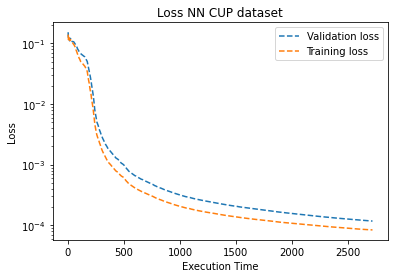

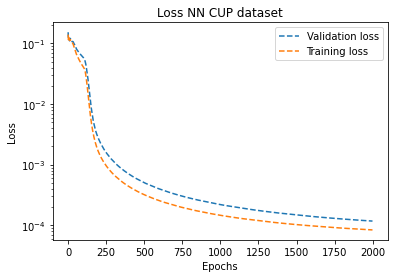

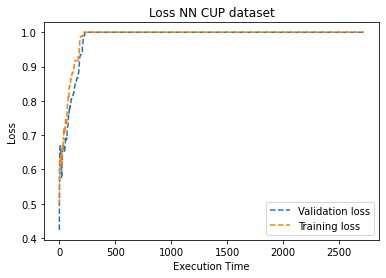

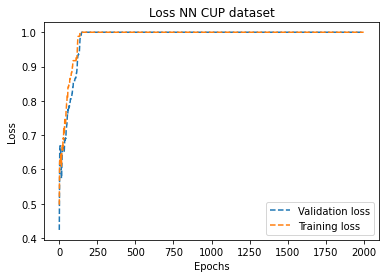

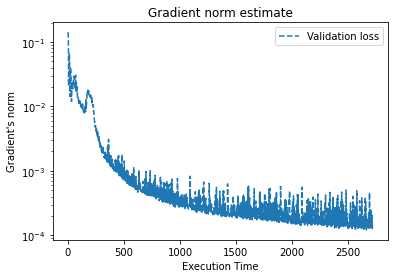

ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 1.45258e-04 | Loss: 1.17702e-04, 8.41359e-05 | Score:     1, 1    
ended in: 2719.264, avg per ep: 1.359632
total update: 0.707, avg updt: 0.0003535
total ff: 6000, total ff time: 1225.4729999999909, avg ff: 0.20424549999999847
total bp: 2000, total bp time: 387.6100000000006, avg bp: 0.19380500000000028
total ev: 2000, total ev time: 1137.0059999999976, avg ev: 0.5685029999999988


----- SGD NAG -----


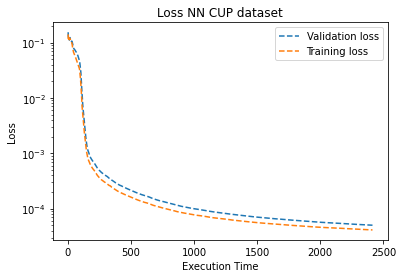

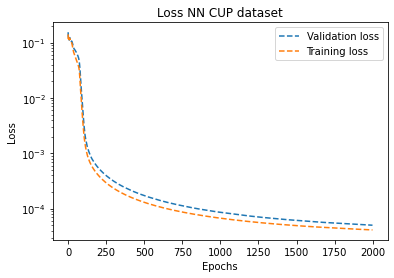

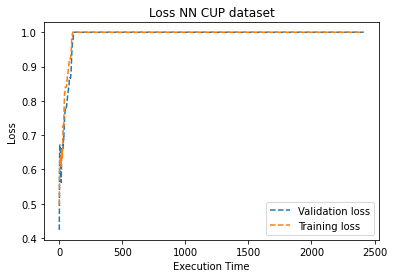

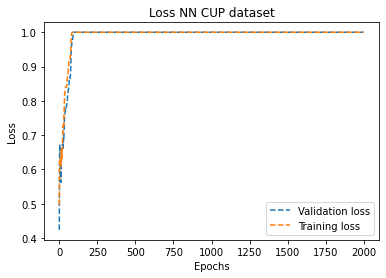

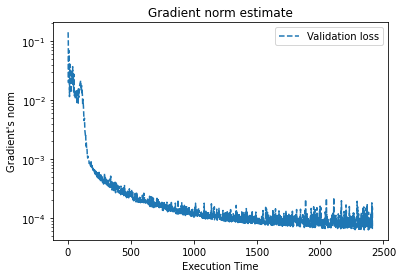

ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 1.51402e-04 | Loss: 5.03087e-05, 4.13614e-05 | Score:     1, 1    
ended in: 2413.6, avg per ep: 1.2067999999999999
total update: 0.643, avg updt: 0.0003215
total ff: 6000, total ff time: 1088.7940000000062, avg ff: 0.18146566666666772
total bp: 2000, total bp time: 272.56900000000104, avg bp: 0.13628450000000053
total ev: 2000, total ev time: 978.8989999999999, avg ev: 0.4894494999999999


----- SGM -----


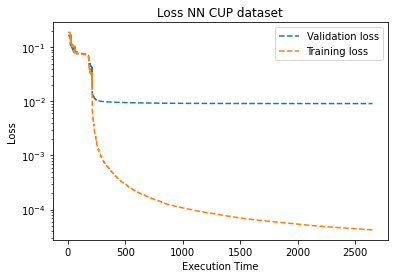

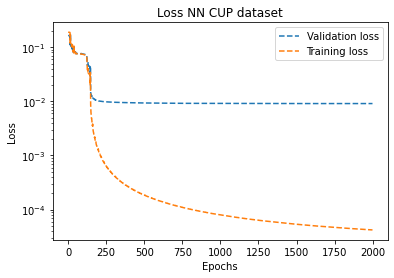

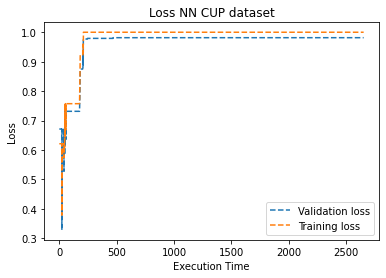

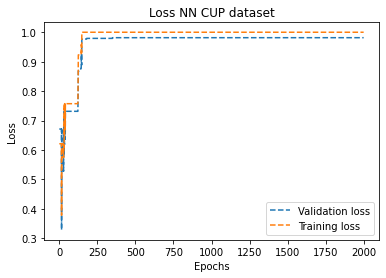

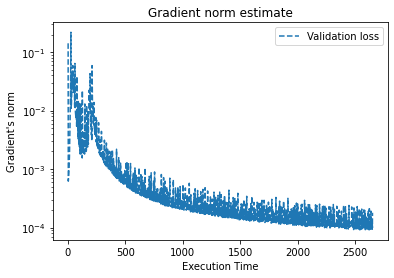

ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 1.78589e-04 | Loss: 9.10886e-03, 4.42667e-05 | Score: 0.981, 1    
ended in: 2651.302, avg per ep: 1.3256510000000001
total update: 0.323, avg updt: 0.0001615
total ff: 6000, total ff time: 994.930999999995, avg ff: 0.1658218333333325
total bp: 2000, total bp time: 617.1529999999985, avg bp: 0.30857649999999925
total ev: 2000, total ev time: 935.2869999999992, avg ev: 0.4676434999999996




<Figure size 432x288 with 0 Axes>

In [14]:
print("----- SGD CM -----")
plot_net(net_SGD, dataset, 'SGD')
print("----- SGD NAG -----")
plot_net(net_SGD_nest, dataset, 'SGD_nest')
print("----- SGM -----")
plot_net(net_SGM, dataset, 'SGM')

### Monk3

In [11]:
dataset = 'monk3'

monk3 = {
     'SGD': {
        'batch_size': None,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.1,
        'lmbda': 0.01,
        'momentum': 0.,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [2],
        'debug': True
    },
    'SGD_nest': {
        'batch_size': None,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.1,
        'lmbda': 0.01,
        'momentum': 0.,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [2],
        'debug': True
    },
    'SGM': {
        'batch_size': None,
        'epochs': 2000,
        'eps':1e-6,
        'eta': 0.1,
        'lmbda': 0.0001,
        'optimizer': "SGM",
        'sizes': [3],
        'debug': True,
    }
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk3'])
nn = NC
    
net_SGD = nn(**monk3['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk3['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGM = nn(**monk3['SGM'])
net_SGM.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 1.07431e-01 || Loss: 1.41250e-01, 1.51523e-01 || Score: 0.528, 0.492
2       || Gradient norm: 1.06029e-01 || Loss: 1.40319e-01, 1.50396e-01 || Score: 0.528, 0.492
3       || Gradient norm: 1.05670e-01 || Loss: 1.39407e-01, 1.49277e-01 || Score: 0.528, 0.492
4       || Gradient norm: 1.05253e-01 || Loss: 1.38502e-01, 1.48168e-01 || Score: 0.528, 0.492
5       || Gradient norm: 1.04951e-01 || Loss: 1.37615e-01, 1.47095e-01 || Score: 0.528, 0.492
6       || Gradient norm: 1.01386e-01 || Loss: 1.36777e-01, 1.46074e-01 || Score: 0.528, 0.492
7       || Gradient norm: 9.88021e-02 || Loss: 1.35980e-01, 1.45116e-01 || Score: 0.528, 0.492
8       || Gradient norm: 9.65953e-02 || Loss: 1.35232e-01, 1.44200e-01 || Score: 0.528, 0.492
9       || Gradient norm: 9.34395e-02 || Loss: 1.34525e-01, 1.43320e-01 || Score: 0.528, 0.492
10      || Gradient norm: 9.41432e-02 || Loss: 1.33826e-01, 1.42433e-01 || Score: 0.528, 0.492
11      || Gradient norm: 9.35639e-02 || Loss: 1.3

NC(batch_size=122, debug=True, epochs=2000, eps=1e-06, optimizer='SGM',
   sizes=[3])

----- SGD CM -----


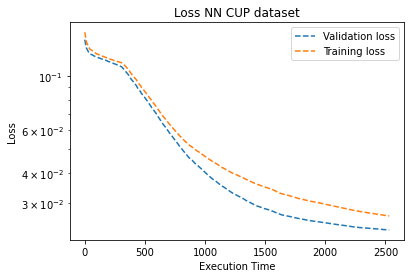

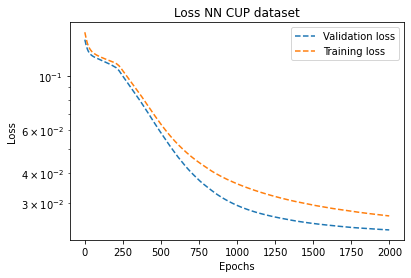

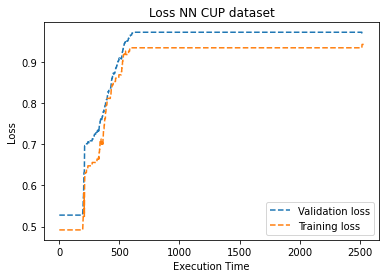

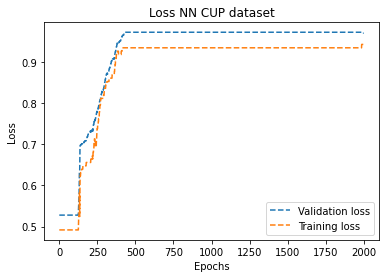

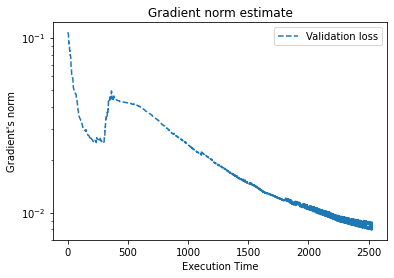

ep: 2000    | s: [2] | b: 122 | e:  0.1 | lmbda: 0.01 | m:  0.0 | nesterov: True
Grad: 8.04368e-03 | Loss: 2.33085e-02, 2.66167e-02 | Score: 0.972, 0.934
ended in: 2531.324, avg per ep: 1.265662
total update: 0.219, avg updt: 0.0001095
total ff: 6000, total ff time: 1123.8530000000076, avg ff: 0.1873088333333346
total bp: 2000, total bp time: 197.83699999999985, avg bp: 0.09891849999999992
total ev: 2000, total ev time: 1667.7120000000025, avg ev: 0.8338560000000013


----- SGD NAG -----


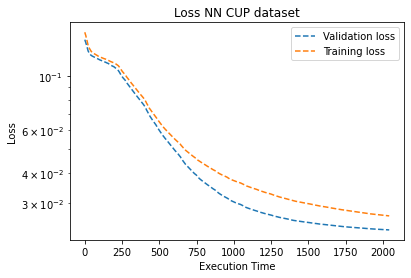

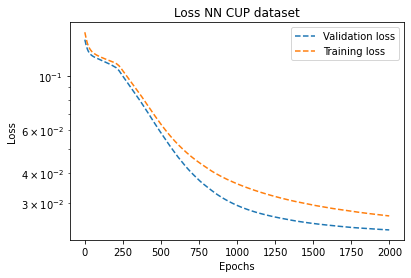

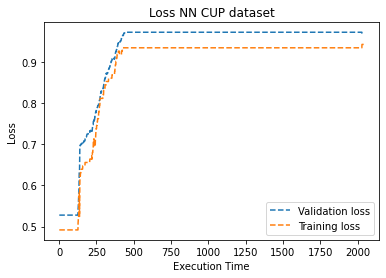

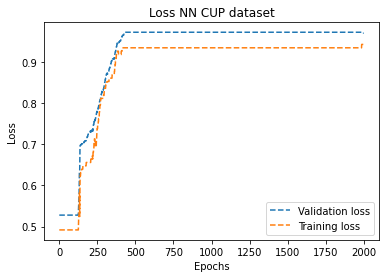

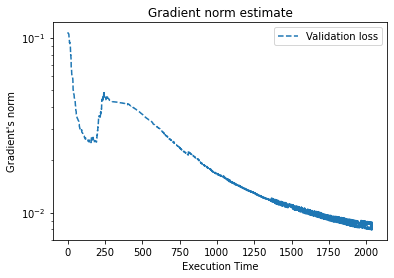

ep: 2000    | s: [2] | b: 122 | e:  0.1 | lmbda: 0.01 | m:  0.0 | nesterov: True
Grad: 8.04368e-03 | Loss: 2.33085e-02, 2.66167e-02 | Score: 0.972, 0.934
ended in: 2041.2, avg per ep: 1.0206
total update: 0.195, avg updt: 9.75e-05
total ff: 6000, total ff time: 894.3830000000047, avg ff: 0.14906383333333412
total bp: 2000, total bp time: 174.3070000000007, avg bp: 0.08715350000000036
total ev: 2000, total ev time: 1317.3139999999983, avg ev: 0.6586569999999992


----- SGM -----


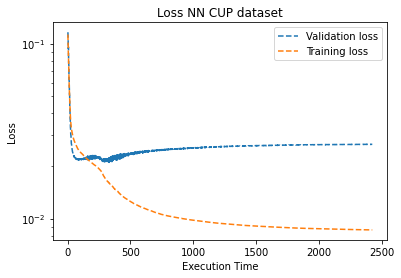

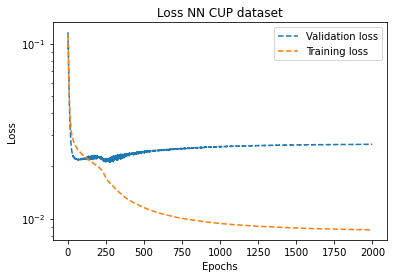

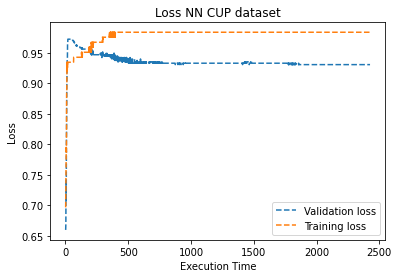

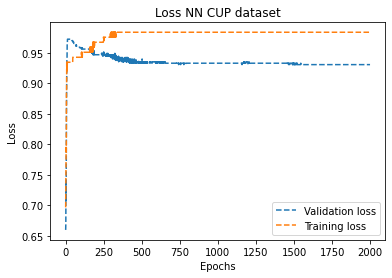

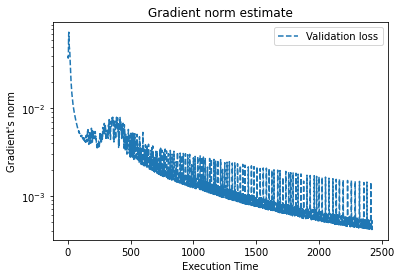

ep: 2000    | s: [3] | b: 122 | e:  0.1 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 4.21357e-04 | Loss: 2.09717e-02, 1.59688e-02 | Score: 0.972, 0.934
ended in: 2426.01, avg per ep: 1.213005
total update: 0.368, avg updt: 0.000184
total ff: 6000, total ff time: 906.2889999999967, avg ff: 0.15104816666666612
total bp: 2000, total bp time: 534.3239999999992, avg bp: 0.26716199999999957
total ev: 2000, total ev time: 1331.834999999999, avg ev: 0.6659174999999995




<Figure size 432x288 with 0 Axes>

In [12]:
print("----- SGD CM -----")
plot_net(net_SGD, dataset, 'SGD')
print("----- SGD NAG -----")
plot_net(net_SGD_nest, dataset, 'SGD_nest')
print("----- SGM -----")
plot_net(net_SGM, dataset, 'SGM')

### CUP

In [16]:
dataset = 'cup'

cup = {
    'SGD': {
        'activation': 'Lrelu',
        'batch_size': None,
        'epochs': 1000,
        'eps': 1e-6,
        'eta': 0.001,
        'lmbda': 0.0001,
        'momentum': 0.9,
        'optimizer': "SGD",
        'sizes': [30, 50],
        'debug': True
    },
    'SGD_nest': {
        'activation': 'Lrelu',
        'batch_size': None,
        'epochs': 1000,
        'eps': 1e-6,
        'eta': 0.001,
        'lmbda': 0.0001,
        'momentum': 0.9,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [30, 50],
        'debug': True
    },
    'SGM': {
        'batch_size': None,
        'epochs': 1000,
        'eps':1e-6,
        'eta': 0.1,
        'lmbda': 0.01,
        'optimizer': "SGM",
        'sizes': [16, 32],
        'debug': True
    }
}
    
X_train, X_test, y_train, y_test = utils.load_CUP(datasets['cup'])
nn = NR
    
net_SGD = nn(**cup['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**cup['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGM = nn(**cup['SGM'])
net_SGM.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 3.11287e+02 || Loss: 8.27447e+02, 8.42175e+02 || Score: -7.99, -8.52
2       || Gradient norm: 3.00226e+02 || Loss: 7.43010e+02, 7.57063e+02 || Score: -7.09, -7.57
3       || Gradient norm: 3.17865e+02 || Loss: 6.12797e+02, 6.25031e+02 || Score: -5.68, -6.08
4       || Gradient norm: 3.92659e+02 || Loss: 3.99264e+02, 4.06454e+02 || Score: -3.36, -3.62
5       || Gradient norm: 4.92136e+02 || Loss: 1.03753e+02, 1.01810e+02 || Score: -0.193, -0.213
6       || Gradient norm: 3.61772e+02 || Loss: 1.99423e+02, 2.17087e+02 || Score: -1.38, -1.68
7       || Gradient norm: 1.03178e+03 || Loss: 3.58979e+02, 3.75363e+02 || Score: -3.03, -3.37
8       || Gradient norm: 1.46678e+03 || Loss: 8.50504e+01, 7.70257e+01 || Score: 0.0552, 0.107
9       || Gradient norm: 3.45074e+02 || Loss: 1.91541e+02, 2.02997e+02 || Score: -1.11, -1.34
10      || Gradient norm: 4.13477e+02 || Loss: 2.50710e+02, 2.67460e+02 || Score: -1.79, -2.1 
11      || Gradient norm: 4.06658e+02 || Loss: 

NR(batch_size=32, debug=True, eps=1e-06, lmbda=0.0001, optimizer='SGM',
   sizes=[50, 50])

----- SGD CM -----


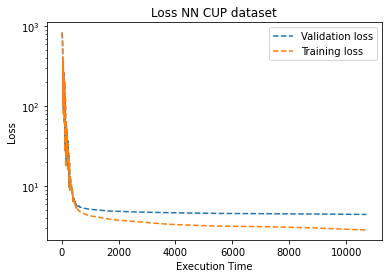

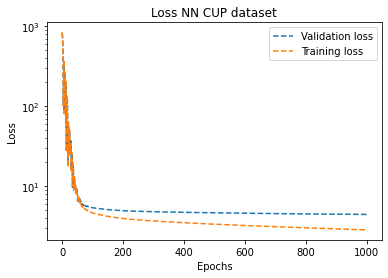

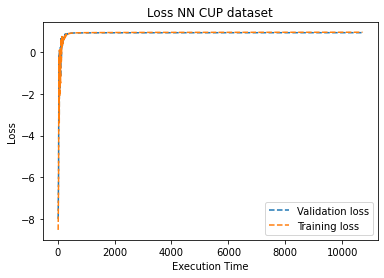

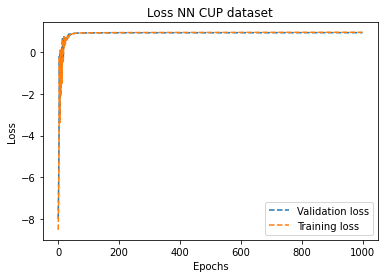

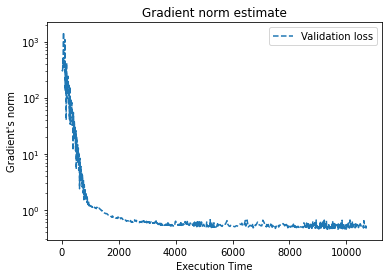

ep: 1000    | s: [30, 50] | b: 1066 | e:0.001 | lmbda:0.0001 | m:  0.9 | nesterov: False
Grad: 4.62797e-01 | Loss: 4.42332e+00, 2.83263e+00 | Score: 0.935, 0.956
ended in: 10710.354, avg per ep: 10.710353999999999
total update: 4.784, avg updt: 0.004784
total ff: 3000, total ff time: 4728.373999999998, avg ff: 1.576124666666666
total bp: 1000, total bp time: 2752.712999999998, avg bp: 2.7527129999999977
total ev: 1000, total ev time: 4745.7160000000085, avg ev: 4.745716000000009


----- SGD NAG -----


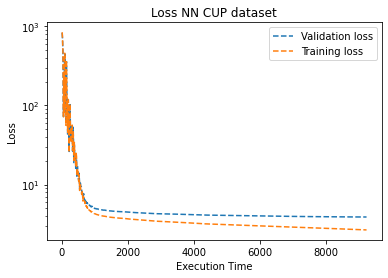

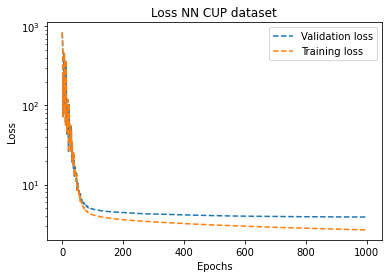

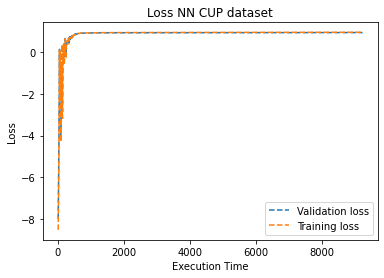

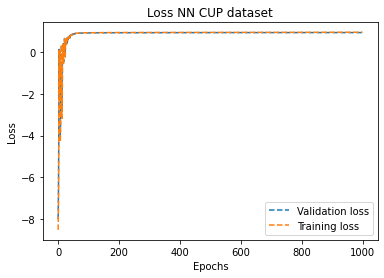

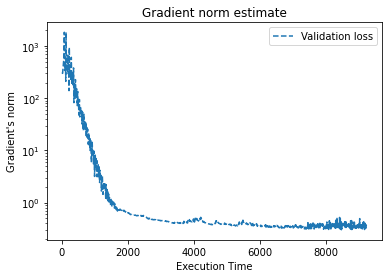

ep: 1000    | s: [30, 50] | b: 1066 | e:0.001 | lmbda:0.0001 | m:  0.9 | nesterov: True
Grad: 3.42099e-01 | Loss: 3.89868e+00, 2.67713e+00 | Score: 0.942, 0.959
ended in: 9220.347, avg per ep: 9.220347
total update: 2.994, avg updt: 0.002994
total ff: 3000, total ff time: 3683.8790000000004, avg ff: 1.2279596666666668
total bp: 1000, total bp time: 1949.9759999999997, avg bp: 1.9499759999999997
total ev: 1000, total ev time: 4377.528, avg ev: 4.377528


----- SGM -----


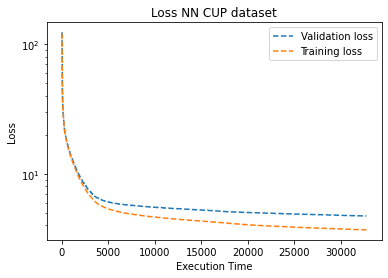

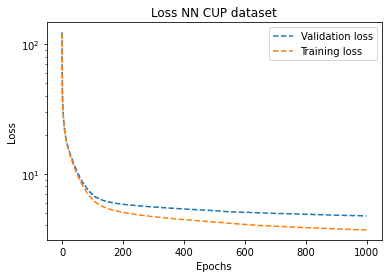

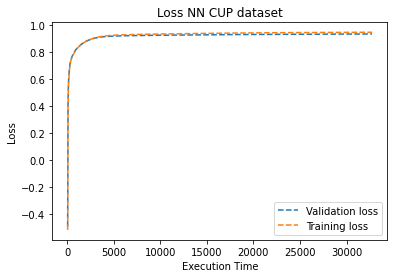

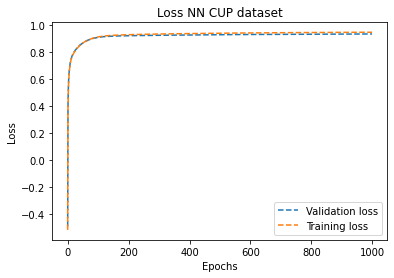

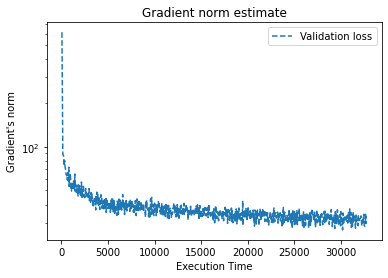

ep: 1000    | s: [50, 50] | b: 32 | e: 0.01 | lmbda:0.0001 | m:  0.0 | nesterov: False
Grad: 8.10967e+01 | Loss: 4.72311e+00, 3.68706e+00 | Score: 0.933, 0.945
ended in: 32735.26, avg per ep: 32.73526
total update: 38.763, avg updt: 0.038763
total ff: 36000, total ff time: 6339.976000000096, avg ff: 0.17611044444444712
total bp: 34000, total bp time: 16021.249000000027, avg bp: 0.4712132058823537
total ev: 1000, total ev time: 3989.6049999999996, avg ev: 3.9896049999999996




<Figure size 432x288 with 0 Axes>

In [17]:
print("----- SGD CM -----")
plot_net(net_SGD, dataset, 'SGD')
print("----- SGD NAG -----")
plot_net(net_SGD_nest, dataset, 'SGD_nest')
print("----- SGM -----")
plot_net(net_SGM, dataset, 'SGM')

# Test convergence to given precision

In [12]:
params_conv = {
    'cup': {
        'SGD': {
            'batch_size': None,
            'eta': 0.001,
            'lmbda': 0.0001,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [30, 50],
        },
        'SGM': {
            'batch_size': None,
            'eta': 0.1,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [16, 32],
        }
    },
    'monk1': {
        'SGD': {
            'batch_size': None,
            'eta': 0.01,
            'lmbda': 0.,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [5],
        },
        'SGM': {
            'batch_size': None,
            'eta': 0.01,
            'lmbda': 0.,
            'optimizer': "SGM",
            'sizes': [5],
        }
    },
    'monk2': {
        'SGD': {
            'batch_size': None,
            'eta': 0.1,
            'lmbda': 0.,
            'momentum': 0.5,
            'optimizer': "SGD",
            'sizes': [3],
        },
        'SGM': {
            'batch_size': None,
            'eta': 0.1,
            'lmbda': 0.,
            'optimizer': "SGM",
            'sizes': [3],
        }
    },
    'monk3': {
        'SGD': {
            'batch_size': None,
            'eta': 0.001,
            'lmbda': 0.001,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [10],
        },
        'SGM': {
            'batch_size': None,
            'eta': 0.001,
            'lmbda': 0.001,
            'optimizer': "SGM",
            'sizes': [10],
        }
    }
}

## SGD

### Monk1

In [8]:
test = "SGD"
dataset = "monk1"
eps = 5e-4
epochs = 10000

params_conv[dataset][test]['eps'] = eps
params_conv[dataset][test]['epochs'] = epochs

m1_sgd_cm = params_conv[dataset][test].copy()
m1_sgd_nag = params_conv[dataset][test].copy()
m1_sgd_nag['nesterov'] = True

X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
nn = NC
    

net = nn(**m1_sgd_cm)
net.fit(X_train, y_train, test_data=(X_test, y_test))

net_nest = nn(**m1_sgd_nag)
net_nest.fit(X_train, y_train, test_data=(X_test, y_test))

0.0004997322187112146 0.0005
Reached desired precision in gradient norm,stopping.


NC(batch_size=124, epochs=10000, eps=0.0005, eta=0.01, lmbda=0.0, momentum=0.9,
   nesterov=True, sizes=[5])

{'batch_size': None, 'eta': 0.01, 'lmbda': 0.0, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'eps': 0.0005, 'epochs': 10000}


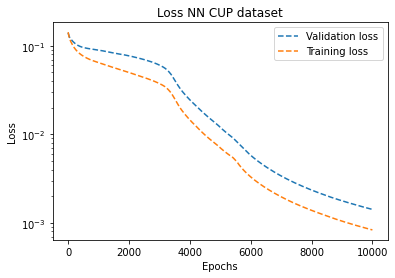

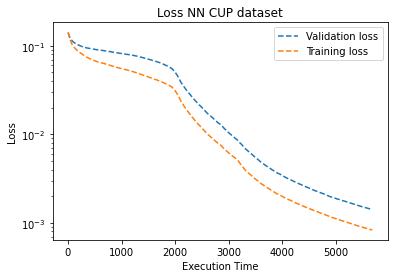

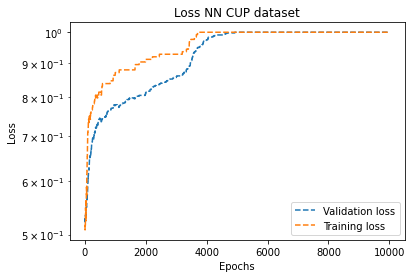

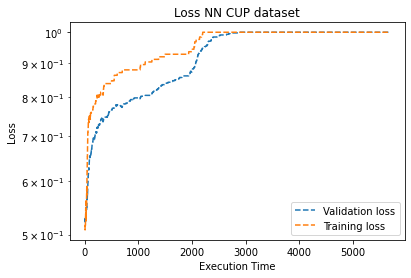

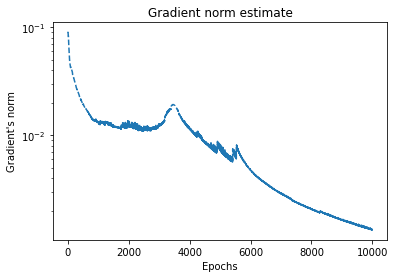

ep: 10000   | s: [5] | b: 124 | e: 0.01 | lmbda:  0.0 | m:  0.9 | nesterov: False
Grad: 1.32969e-03 | Loss: 1.41768e-03, 8.31630e-04 | Score:     1, 1    
ended in: 5679.656, avg per ep: 0.5679656
total update: 0.378, avg updt: 3.78e-05
total ff: 30000, total ff time: 2062.294000000404, avg ff: 0.0687431333333468
total bp: 10000, total bp time: 847.9420000000099, avg bp: 0.08479420000000099
total ev: 10000, total ev time: 2913.2060000000165, avg ev: 0.29132060000000165


{'batch_size': None, 'eta': 0.01, 'lmbda': 0.0, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'eps': 0.0005, 'epochs': 10000, 'nesterov': True}


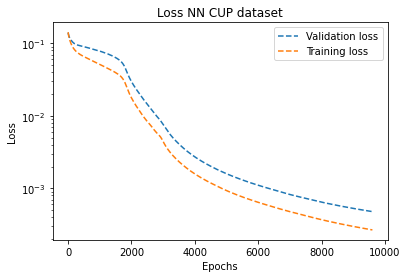

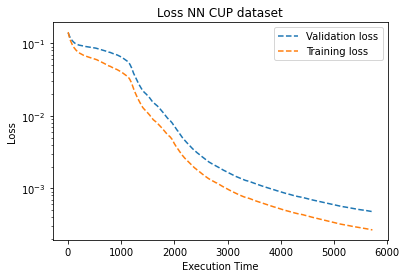

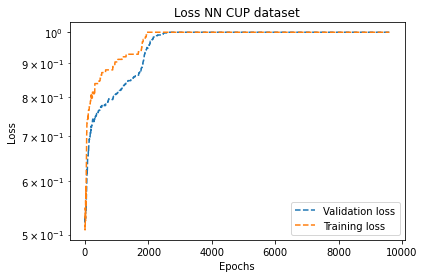

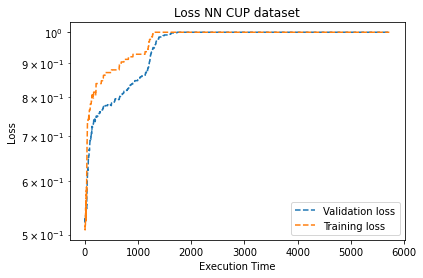

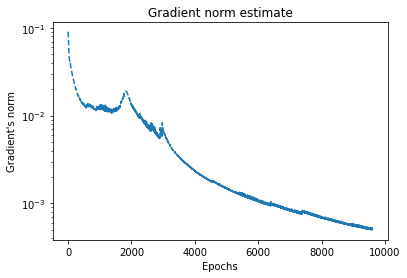

ep: 10000   | s: [5] | b: 124 | e: 0.01 | lmbda:  0.0 | m:  0.9 | nesterov: True
Grad: 4.99732e-04 | Loss: 4.78446e-04, 2.67642e-04 | Score:     1, 1    
ended in: 5725.1939999999995, avg per ep: 0.5725193999999999
total update: 0.216, avg updt: 2.16e-05
total ff: 28812, total ff time: 2013.321000000251, avg ff: 0.06987786339026276
total bp: 9604, total bp time: 808.4860000000269, avg bp: 0.08418221574344303
total ev: 9604, total ev time: 2882.6870000000354, avg ev: 0.3001548313202869




<Figure size 432x288 with 0 Axes>

In [9]:
plot_stats(m1_sgd_cm, dataset=dataset, test=test, net=net, log=True)
plot_stats(m1_sgd_nag, dataset=dataset, test=test, net=net_nest, log=True)

### Monk2

In [10]:
test = "SGD"
dataset = "monk2"
eps = 5e-4
epochs = 10000

params_conv[dataset][test]['eps'] = eps
params_conv[dataset][test]['epochs'] = epochs

m2_sgd_cm = params_conv[dataset][test].copy()
m2_sgd_nag = params_conv[dataset][test].copy()
m2_sgd_nag['nesterov'] = True

X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
nn = NC

net_cm = nn(**m2_sgd_cm)
net_cm.fit(X_train, y_train, test_data=(X_test, y_test))

net_nag = nn(**m2_sgd_nag)
net_nag.fit(X_train, y_train, test_data=(X_test, y_test))

0.0004993934947309555 0.0005
Reached desired precision in gradient norm,stopping.


NC(batch_size=169, epochs=10000, eps=0.0005, lmbda=0.0, nesterov=True,
   sizes=[3])

{'batch_size': None, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [3], 'eps': 0.0005, 'epochs': 10000}


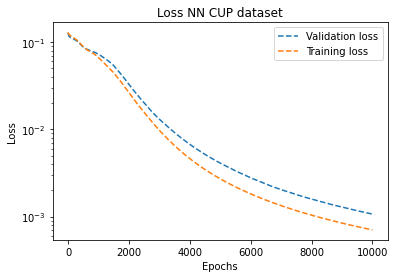

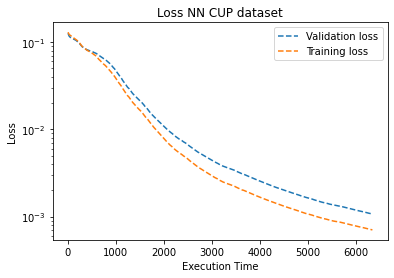

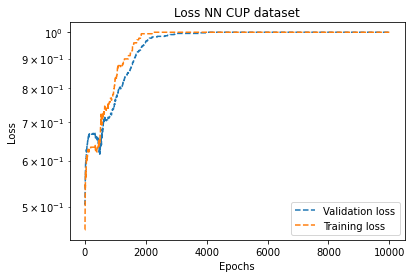

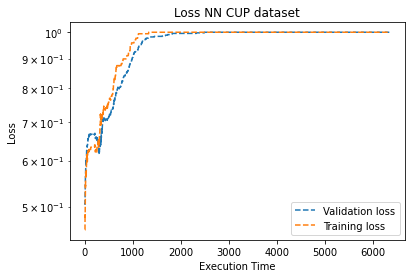

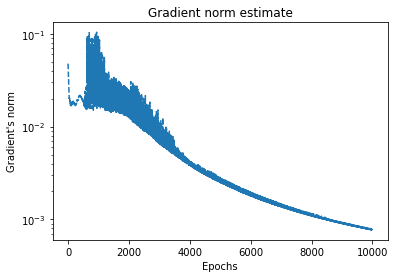

ep: 10000   | s: [3] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 7.70634e-04 | Loss: 1.07087e-03, 7.05125e-04 | Score:     1, 1    
ended in: 6348.229, avg per ep: 0.6348229000000001
total update: 0.211, avg updt: 2.1099999999999998e-05
total ff: 30000, total ff time: 2300.4739999999424, avg ff: 0.07668246666666474
total bp: 10000, total bp time: 948.4910000000168, avg bp: 0.09484910000000168
total ev: 10000, total ev time: 3237.59600000004, avg ev: 0.323759600000004


{'batch_size': None, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [3], 'eps': 0.0005, 'epochs': 10000, 'nesterov': True}


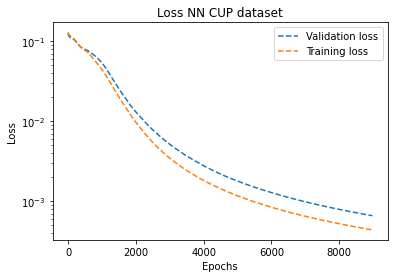

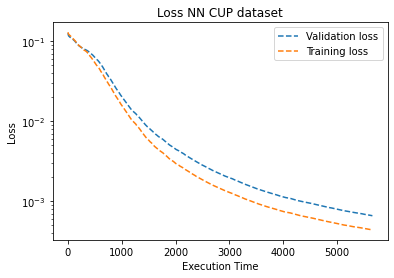

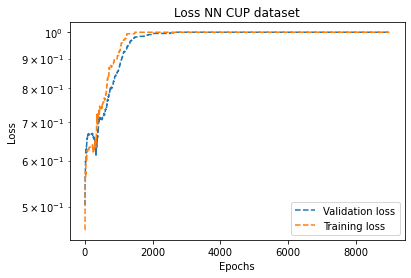

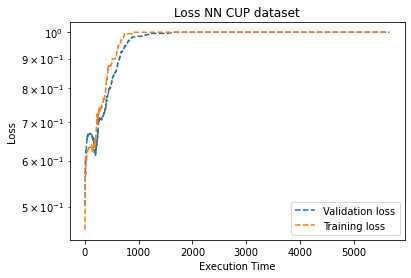

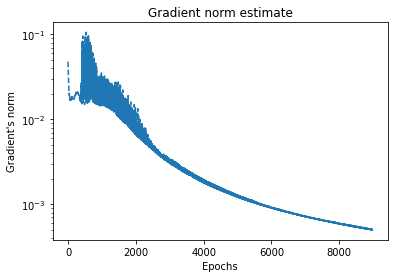

ep: 10000   | s: [3] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: True
Grad: 4.99393e-04 | Loss: 6.60379e-04, 4.38903e-04 | Score:     1, 1    
ended in: 5662.993, avg per ep: 0.5662993000000001
total update: 0.203, avg updt: 2.0300000000000002e-05
total ff: 26949, total ff time: 1990.3020000001034, avg ff: 0.07385439162863569
total bp: 8983, total bp time: 834.6910000000132, avg bp: 0.09291895803183939
total ev: 8983, total ev time: 2813.7530000000183, avg ev: 0.3132308805521561




<Figure size 432x288 with 0 Axes>

In [11]:
plot_stats(m2_sgd_cm, dataset=dataset, test=test, net=net_cm, log=True)
plot_stats(m2_sgd_nag, dataset=dataset, test=test, net=net_nag, log=True)

### Monk3

In [12]:
test = "SGD"
dataset = "monk3"
eps = 1e-3
epochs = 10000

params_conv[dataset][test]['eps'] = eps
params_conv[dataset][test]['epochs'] = epochs

m3_sgd_cm = params_conv[dataset][test].copy()
m3_sgd_nag = params_conv[dataset][test].copy()
m3_sgd_nag['nesterov'] = True

X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
nn = NC

net_cm = nn(**m3_sgd_cm)
net_cm.fit(X_train, y_train, test_data=(X_test, y_test))

net_nag = nn(**m3_sgd_nag)
net_nag.fit(X_train, y_train, test_data=(X_test, y_test))

NC(batch_size=122, epochs=10000, eps=0.001, eta=0.001, lmbda=0.001,
   momentum=0.9, nesterov=True, sizes=[10])

{'batch_size': None, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [10], 'eps': 0.001, 'epochs': 10000}


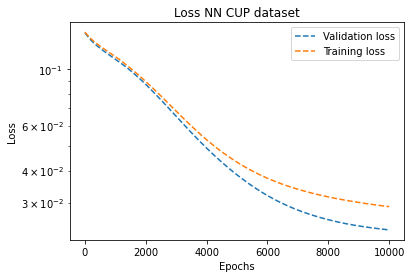

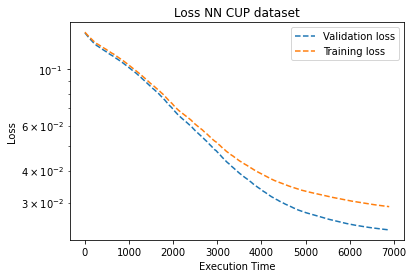

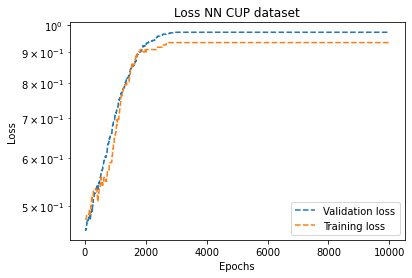

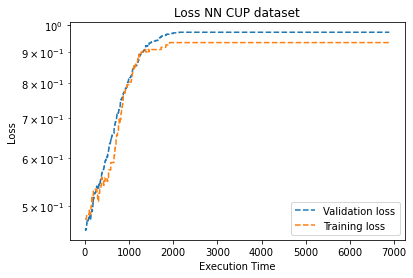

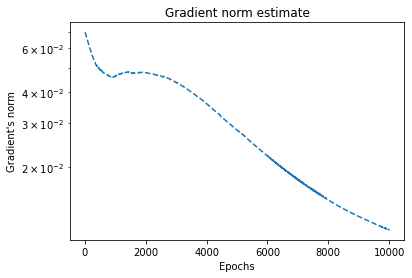

ep: 10000   | s: [10] | b: 122 | e:0.001 | lmbda:0.001 | m:  0.9 | nesterov: False
Grad: 1.11938e-02 | Loss: 2.34511e-02, 2.89113e-02 | Score: 0.972, 0.934
ended in: 6893.034, avg per ep: 0.6893034
total update: 0.281, avg updt: 2.8100000000000002e-05
total ff: 30000, total ff time: 2712.306000000007, avg ff: 0.09041020000000023
total bp: 10000, total bp time: 1028.4440000000027, avg bp: 0.10284440000000027
total ev: 10000, total ev time: 3612.549999999997, avg ev: 0.3612549999999997


{'batch_size': None, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [10], 'eps': 0.001, 'epochs': 10000, 'nesterov': True}


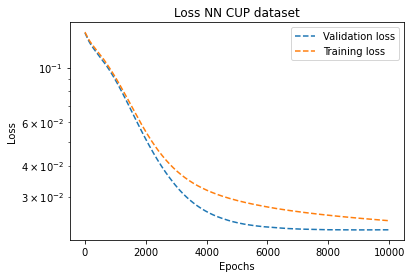

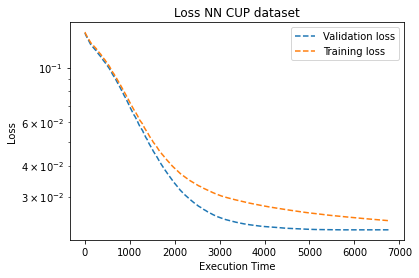

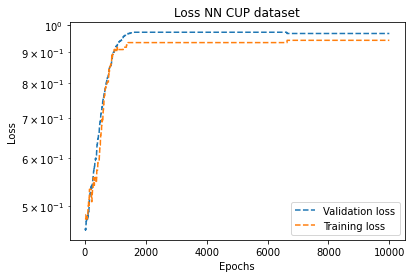

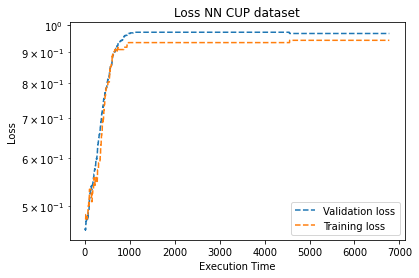

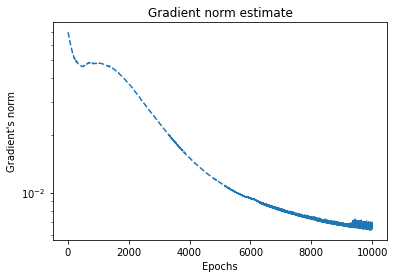

ep: 10000   | s: [10] | b: 122 | e:0.001 | lmbda:0.001 | m:  0.9 | nesterov: True
Grad: 6.43716e-03 | Loss: 2.19619e-02, 2.42894e-02 | Score: 0.972, 0.934
ended in: 6774.969, avg per ep: 0.6774969
total update: 0.229, avg updt: 2.29e-05
total ff: 30000, total ff time: 2589.535000000022, avg ff: 0.08631783333333407
total bp: 10000, total bp time: 981.6660000000068, avg bp: 0.09816660000000067
total ev: 10000, total ev time: 3463.6710000000007, avg ev: 0.3463671000000001




<Figure size 432x288 with 0 Axes>

In [13]:
plot_stats(m3_sgd_cm, dataset=dataset, test=test, net=net_cm, log=True)
plot_stats(m3_sgd_nag, dataset=dataset, test=test, net=net_nag, log=True)

### Cup

In [13]:
test = "SGD"
dataset = "cup"
eps = 5e-3
epochs = 10000

params_conv[dataset][test]['eps'] = eps
params_conv[dataset][test]['epochs'] = epochs

cup_sgd = params_conv[dataset][test].copy()

X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
nn = NR
    
net = nn(**cup_sgd)
net.fit(X_train, y_train, test_data=(X_test, y_test))

NR(batch_size=1066, epochs=10000, eps=0.005, eta=0.001, lmbda=0.0001,
   momentum=0.9, sizes=[30, 50])

{'batch_size': None, 'eta': 0.001, 'lmbda': 0.0001, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [30, 50], 'eps': 0.005, 'epochs': 10000}


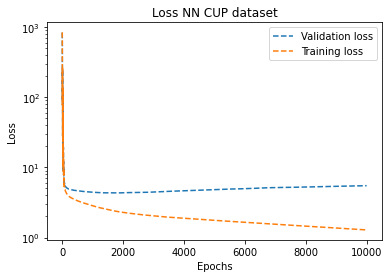

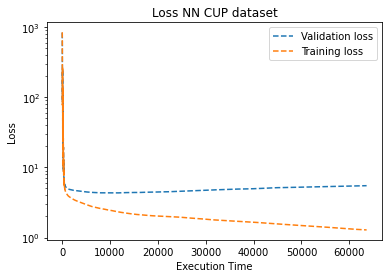

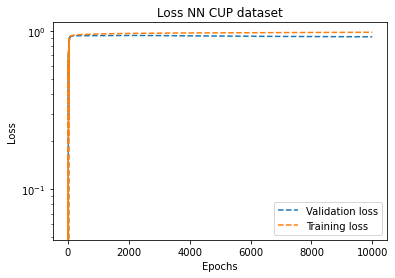

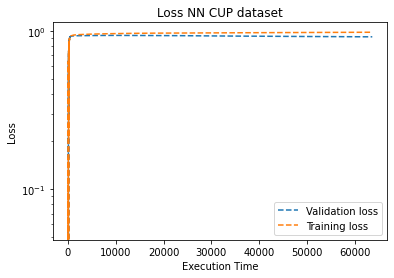

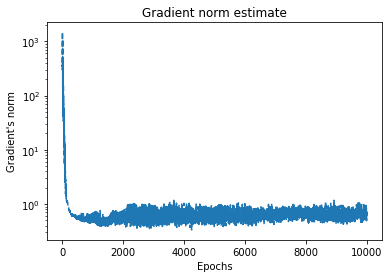

ep: 10000   | s: [30, 50] | b: 1066 | e:0.001 | lmbda:0.0001 | m:  0.9 | nesterov: False
Grad: 6.96868e-01 | Loss: 4.30564e+00, 2.38285e+00 | Score: 0.937, 0.963
ended in: 63633.286, avg per ep: 6.3633286
total update: 3.896, avg updt: 0.0003896
total ff: 30000, total ff time: 31377.57600000025, avg ff: 1.0459192000000084
total bp: 10000, total bp time: 17102.132000000005, avg bp: 1.7102132000000005
total ev: 10000, total ev time: 31171.793999999987, avg ev: 3.1171793999999986




<Figure size 432x288 with 0 Axes>

In [14]:
plot_stats(cup_sgd, dataset=dataset, test=test, net=net, log=True)

## SGM

### Monk1

In [16]:
test = "SGM"
dataset = "monk1"
eps = 5e-4
epochs = 10000

params_conv[dataset][test]['eps'] = eps
params_conv[dataset][test]['epochs'] = epochs

m1_sgm = params_conv[dataset][test].copy()

X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
nn = NC
    

net = nn(**m1_sgm)
net.fit(X_train, y_train, test_data=(X_test, y_test))

NC(batch_size=124, epochs=10000, eps=0.0005, eta=0.01, lmbda=0.0,
   optimizer='SGM', sizes=[5])

{'batch_size': None, 'eta': 0.01, 'lmbda': 0.0, 'optimizer': 'SGM', 'sizes': [5], 'eps': 0.0005, 'epochs': 10000}


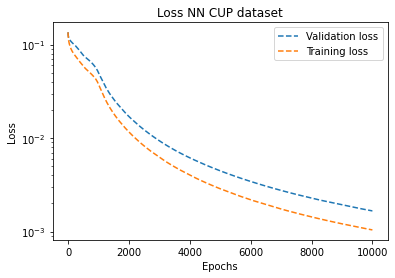

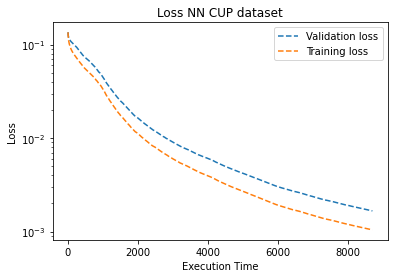

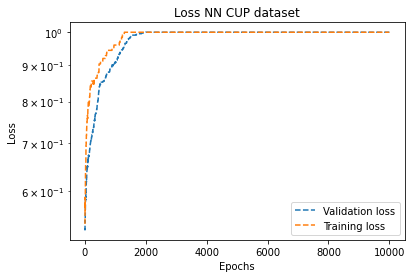

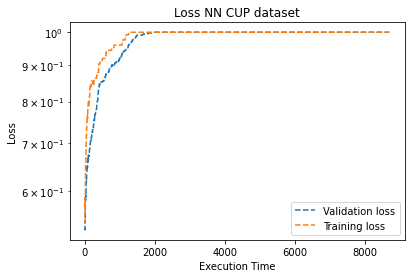

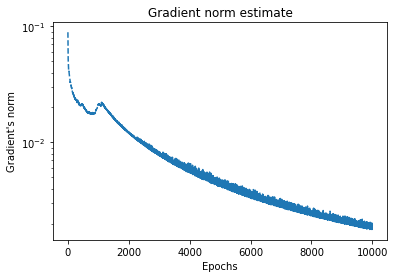

ep: 10000   | s: [5] | b: 124 | e: 0.01 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 1.96809e-03 | Loss: 1.66659e-03, 1.04350e-03 | Score:     1, 1    
ended in: 8696.089, avg per ep: 0.8696089
total update: 0.36, avg updt: 3.6e-05
total ff: 30000, total ff time: 2530.27899999976, avg ff: 0.08434263333332533
total bp: 10000, total bp time: 2533.474999999966, avg bp: 0.25334749999999656
total ev: 10000, total ev time: 3565.1060000000066, avg ev: 0.3565106000000007




<Figure size 432x288 with 0 Axes>

In [17]:
plot_stats(m1_sgm, dataset=dataset, test=test, net=net, log=True)

### Monk2

In [18]:
test = "SGM"
dataset = "monk2"
eps = 5e-6
epochs = 10000

params_conv[dataset][test]['eps'] = eps
params_conv[dataset][test]['epochs'] = epochs

m2_sgm = params_conv[dataset][test].copy()

X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
nn = NC
    

net = nn(**m2_sgm)
net.fit(X_train, y_train, test_data=(X_test, y_test))

NC(batch_size=169, epochs=10000, eps=5e-06, lmbda=0.0, optimizer='SGM',
   sizes=[3])

{'batch_size': None, 'eta': 0.1, 'lmbda': 0.0, 'optimizer': 'SGM', 'sizes': [3], 'eps': 5e-06, 'epochs': 10000}


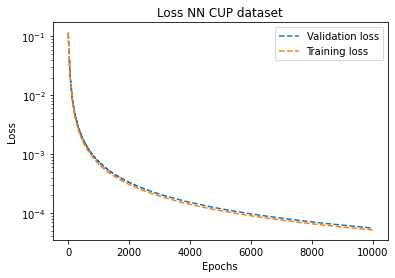

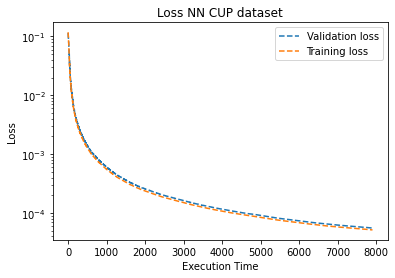

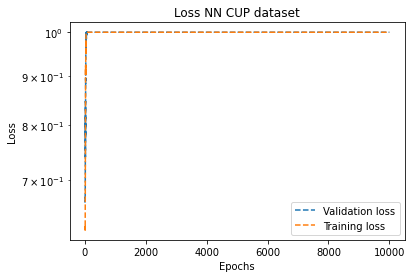

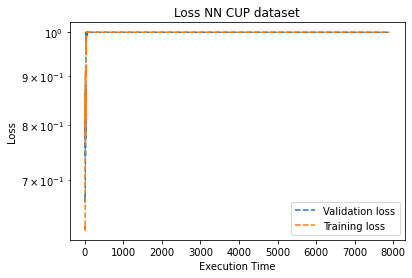

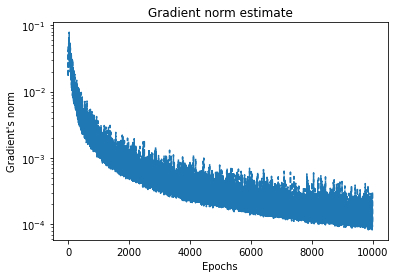

ep: 10000   | s: [3] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 1.06317e-04 | Loss: 5.53978e-05, 5.15298e-05 | Score:     1, 1    
ended in: 7902.74, avg per ep: 0.790274
total update: 0.358, avg updt: 3.5799999999999996e-05
total ff: 30000, total ff time: 2220.3869999998587, avg ff: 0.07401289999999529
total bp: 10000, total bp time: 2358.4150000000072, avg bp: 0.23584150000000073
total ev: 10000, total ev time: 3159.849999999981, avg ev: 0.3159849999999981




<Figure size 432x288 with 0 Axes>

In [19]:
plot_stats(m2_sgm, dataset=dataset, test=test, net=net, log=True)

### Monk3

In [20]:
test = "SGM"
dataset = "monk3"
eps = 5e-3
epochs = 10000

params_conv[dataset][test]['eps'] = eps
params_conv[dataset][test]['epochs'] = epochs

m3_sgm = params_conv[dataset][test].copy()

X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
nn = NC
    
net = nn(**m3_sgm)
net.fit(X_train, y_train, test_data=(X_test, y_test))

NC(batch_size=122, epochs=10000, eps=0.005, eta=0.001, lmbda=0.001,
   optimizer='SGM', sizes=[10])

{'batch_size': None, 'eta': 0.001, 'lmbda': 0.001, 'optimizer': 'SGM', 'sizes': [10], 'eps': 0.005, 'epochs': 10000}


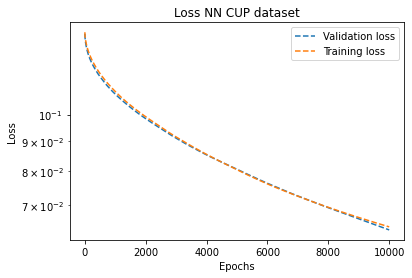

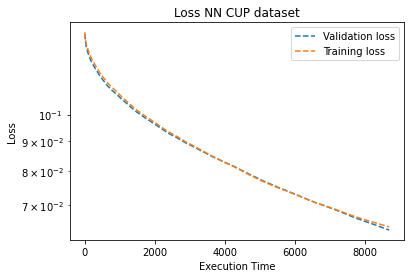

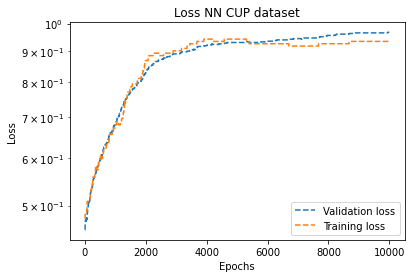

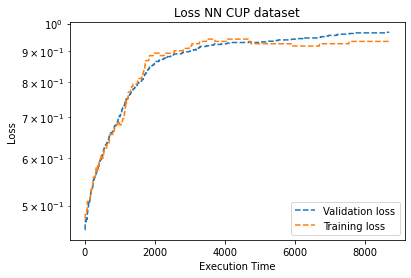

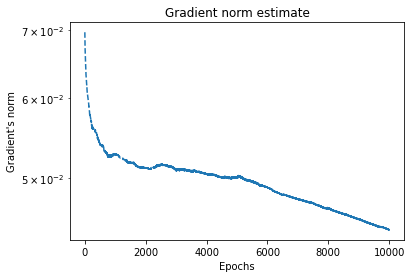

ep: 10000   | s: [10] | b: 122 | e:0.001 | lmbda:0.001 | m:  0.5 | nesterov: False
Grad: 4.44879e-02 | Loss: 6.34485e-02, 6.42149e-02 | Score: 0.968, 0.934
ended in: 8695.744, avg per ep: 0.8695744000000001
total update: 0.587, avg updt: 5.87e-05
total ff: 30000, total ff time: 2676.6530000000826, avg ff: 0.08922176666666942
total bp: 10000, total bp time: 2538.5650000000096, avg bp: 0.253856500000001
total ev: 10000, total ev time: 3584.5109999999636, avg ev: 0.35845109999999636




<Figure size 432x288 with 0 Axes>

In [21]:
plot_stats(m3_sgm, dataset=dataset, test=test, net=net, log=True)

### Cup

In [15]:
test = "SGM"
dataset = "cup"
eps = 5e-3
epochs = 10000

params_conv[dataset][test]['eps'] = eps
params_conv[dataset][test]['epochs'] = epochs

cup_sgm = params_conv[dataset][test].copy()

X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
nn = NR
    
net = nn(**cup_sgm)
net.fit(X_train, y_train, test_data=(X_test, y_test))

NR(batch_size=1066, epochs=10000, eps=0.005, eta=0.1, lmbda=0.01,
   optimizer='SGM', sizes=[16, 32])

{'batch_size': None, 'eta': 0.1, 'lmbda': 0.01, 'optimizer': 'SGM', 'sizes': [16, 32], 'eps': 0.005, 'epochs': 10000}


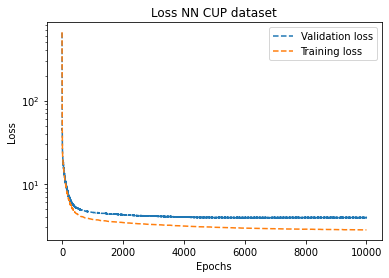

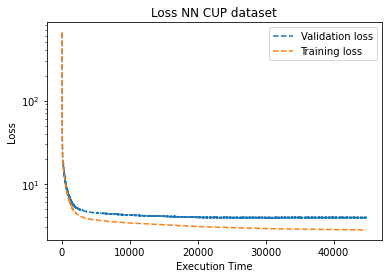

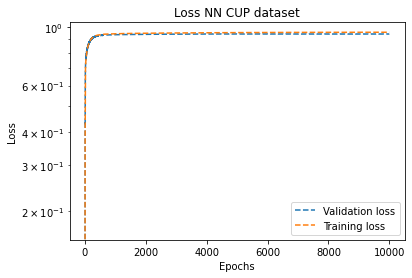

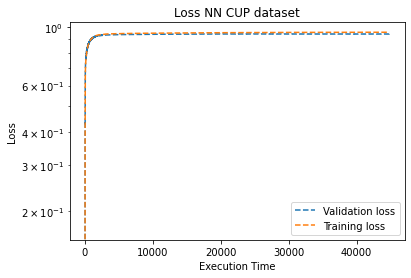

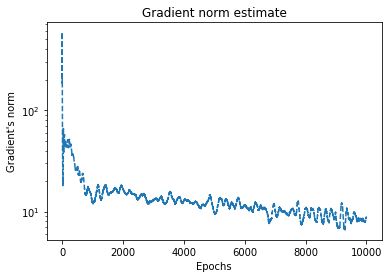

ep: 10000   | s: [16, 32] | b: 1066 | e:  0.1 | lmbda: 0.01 | m:  0.0 | nesterov: False
Grad: 8.61709e+00 | Loss: 3.91788e+00, 2.89049e+00 | Score: 0.942, 0.954
ended in: 44824.789, avg per ep: 4.482478899999999
total update: 1.816, avg updt: 0.0001816
total ff: 30000, total ff time: 16524.8810000001, avg ff: 0.5508293666666699
total bp: 10000, total bp time: 13954.664000000024, avg bp: 1.3954664000000023
total ev: 10000, total ev time: 21597.77500000004, avg ev: 2.159777500000004




<Figure size 432x288 with 0 Axes>

In [16]:
plot_stats(cup_sgm, dataset=dataset, test=test, net=net, log=True)

# Report stats

## Monk1

In [6]:
debug = False
score = False
dataset = 'monk1'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.5, 'lmbda': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 32 | e:  0.5 | lmbda:0.001 | m:  0.9 | nesterov: True
Grad: 2.89981e-04 | Loss: -1.00000e+00, 1.58541e-07 | Score:    -1, 1    
ended in: 2173.889, avg per ep: 1.0869445
total update: 0.765, avg updt: 0.00038250000000000003
total ff: 10000, total ff time: 533.0039999999951, avg ff: 0.05330039999999951
total bp: 8000, total bp time: 550.2759999999953, avg bp: 0.06878449999999942
total ev: 2000, total ev time: 299.52499999999964, avg ev: 0.14976249999999983

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.5, 'lmbda': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 32 | e:  0.5 | lmbda:0.001 | m:  0.9 | nesterov: True
Grad: 2.89981e-04 | Lo

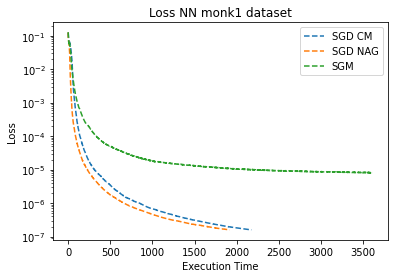

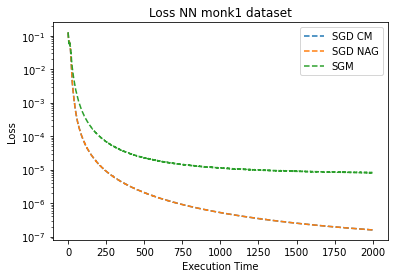

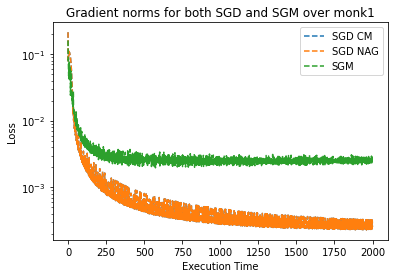

<Figure size 432x288 with 0 Axes>

In [7]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## Monk2

In [8]:
debug = False
score = False
dataset = 'monk2'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.7, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 3.83346e-04 | Loss: -1.00000e+00, 7.09534e-07 | Score:    -1, 1    
ended in: 895.65, avg per ep: 0.447825
total update: 0.314, avg updt: 0.000157
total ff: 4000, total ff time: 268.66400000000164, avg ff: 0.0671660000000004
total bp: 2000, total bp time: 191.10099999999872, avg bp: 0.09555049999999936
total ev: 2000, total ev time: 298.066000000001, avg ev: 0.1490330000000005

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.7, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 1.56601e-04 | Loss: -1.00000e+00, 1.76782e-07 | Score:    -1, 1    

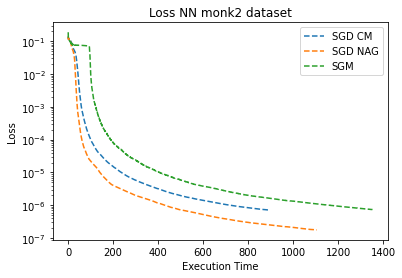

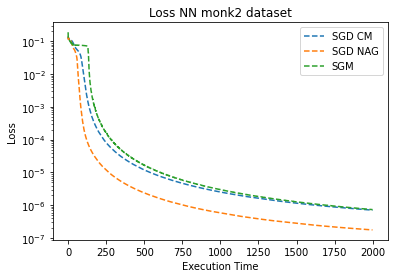

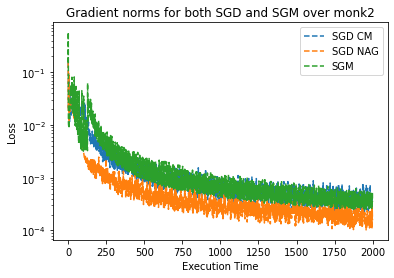

<Figure size 432x288 with 0 Axes>

In [9]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## Monk3

In [10]:
debug = False
score = False
dataset = 'monk3'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.7, 'lmbda': 0.001, 'momentum': 0.5, 'nesterov': True, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 32 | e:  0.7 | lmbda:0.001 | m:  0.5 | nesterov: True
Grad: 3.73444e-03 | Loss: -1.00000e+00, 1.57477e-05 | Score:    -1, 1    
ended in: 2404.13, avg per ep: 1.2020650000000002
total update: 0.7, avg updt: 0.00035
total ff: 10000, total ff time: 598.2490000000049, avg ff: 0.05982490000000049
total bp: 8000, total bp time: 605.2349999999999, avg bp: 0.07565437499999998
total ev: 2000, total ev time: 329.9790000000003, avg ev: 0.16498950000000015

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.7, 'lmbda': 0.001, 'momentum': 0.5, 'nesterov': True, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 32 | e:  0.7 | lmbda:0.001 | m:  0.5 | nesterov: True
Grad: 3.73444e-03 | Loss: -1.000

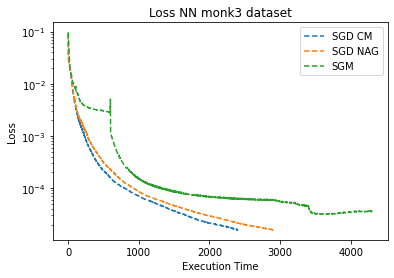

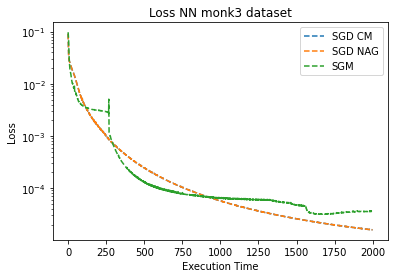

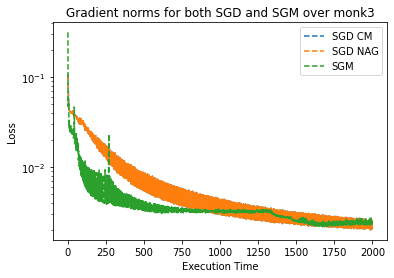

<Figure size 432x288 with 0 Axes>

In [11]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## CUP

In [12]:
debug = False
score = False
dataset = 'cup'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'batch_size': 32, 'epochs': 1000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.0, 'optimizer': 'SGD', 'sizes': [30, 50], 'activation': 'Lrelu', 'debug': True}
ep: 1000    | s: [30, 50] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0 | nesterov: False
Grad: 3.75936e+01 | Loss: -1.00000e+00, 2.77330e+00 | Score:    -1, 0.958
ended in: 16073.872, avg per ep: 16.073871999999998
total update: 11.455, avg updt: 0.011455
total ff: 35000, total ff time: 5070.278000000366, avg ff: 0.14486508571429615
total bp: 34000, total bp time: 5253.797000000046, avg bp: 0.15452344117647193
total ev: 1000, total ev time: 2096.721999999996, avg ev: 2.096721999999996

 

----- SGD nesterov-----
{'batch_size': 32, 'epochs': 1000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.0, 'optimizer': 'SGD', 'sizes': [30, 50], 'activation': 'Lrelu', 'debug': True}
ep: 1000    | s: [30, 50] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0 | nesterov: True
Grad: 3.75936e+01 | Loss: -1.00000e+00

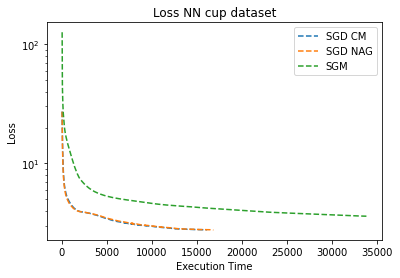

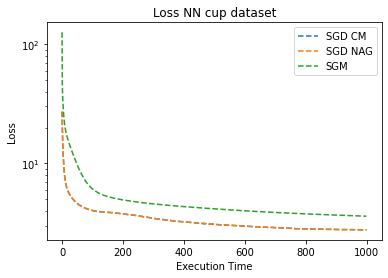

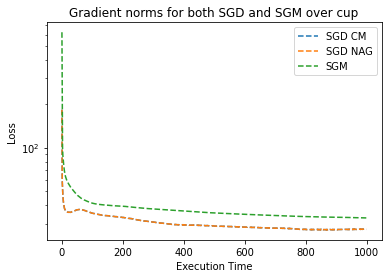

<Figure size 432x288 with 0 Axes>

In [13]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)